# Figure 1.b - Supervised model performance

Goals : 

- Show that 3D models outperform usual 2D models

In [1]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

Used GPU:  <NVIDIA GeForce RTX 4070 Ti on Platform: NVIDIA CUDA (1 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [2]:
%load_ext autoreload
%autoreload 2

## Data

In [3]:
data_path = DATA_PATH / "RESULTS/SUPERVISED_PERF_FIG/INFERENCE"
fold1_path = data_path / "fold1"
fold2_path = data_path / "fold2"
fold3_path = data_path / "fold3"

def get_fold_data(fold_path):
    return [imread(f) for f in fold_path.glob("*.tif") if "label" not in f.name], [imread(f) for f in fold_path.glob("*.tif") if "label" in f.name]

images = []
GT_labels = []
for fold in [fold1_path, fold2_path, fold3_path]:
    im, GT_lab = get_fold_data(fold)
    images.append(im[0])
    GT_labels.append(GT_lab[0])

In [4]:
fold_paths = [fold1_path, fold2_path, fold3_path]

def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
swin_paths = [f / "Swin" for f in fold_paths]
segresnet_paths = [f / "SegResNet" for f in fold_paths]
#################
cellpose_paths = [f / "Cellpose" for f in fold_paths]
stardist_paths = [f / "starDist" for f in fold_paths]

swin_predictions = [get_predictions(p)[0] for p in swin_paths]
segresnet_predictions = [get_predictions(p)[0] for p in segresnet_paths]
cellpose_predictions = [get_predictions(p)[0] for p in cellpose_paths]
stardist_predictions = [get_predictions(p)[0] for p in stardist_paths]

In [5]:
wnet_path = DATA_PATH / "RESULTS/WNET_RETRAIN/inference/WNet"
wnet_instance = [imread(str(f)) for f in wnet_path.glob("*.tif")]
wnet_instance.reverse()

## Computations

For the choice of thresholds, see notebooks in the `thresholds_opti/` folder.

In [6]:
swin_thresholded = [np.where(swin > 0.4, swin, 0) for swin in swin_predictions]
segresnet_thresholded = [np.where(segresnet > 0.3, segresnet, 0) for segresnet in segresnet_predictions]

In [7]:
swin_instance = []
segresnet_instance = []

for i in range(len(fold_paths)):
    swin_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                         )
    segresnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(segresnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                              )

In [8]:
# from tifffile import imwrite
# for i in range(len(fold_paths)):
#     save_folder = data_path / f"fold{i+1}" / "processed"
#     save_folder.mkdir(exist_ok=True, parents=False)
#     imwrite(save_folder / "swin_instance.tif", swin_instance[i])
#     imwrite(save_folder / "segresnet_instance.tif", segresnet_instance[i])

## Plots

In [9]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [
   stardist_predictions,
   cellpose_predictions,
   segresnet_instance,
   swin_instance,
   wnet_instance
   ]
names = [
    "StarDist",
    "Cellpose",
    "SegResNet",
    "SwinUNetR",
    "WNet3D"
    ]

model_stats = []
model_ref_name = []
fold_ref = []

for j, fold in enumerate(fold_paths):
    print("Fold ", j+1)
    for i, p in enumerate(predictions):
        print(f"Validating on {names[i]}")
        # print(p[j].shape, GT_labels[j].shape)
        pred = p[j]
        if len(pred.shape) > 3:
            pred = pred.squeeze().astype(np.uint32)
        stats = [matching_dataset(
            GT_labels[j], pred, thresh=t, show_progress=False
            ) for t in taus]
        model_stats.append(stats)
        for t in taus:
            model_ref_name.append(names[i])
            fold_ref.append(j+1)
        # uncomment for ALL plots : 
        # plot_performance(taus, stats, name=names[i])
        print("*"*20)

Fold  1
Validating on StarDist
********************
Validating on Cellpose
********************
Validating on SegResNet
********************
Validating on SwinUNetR
********************
Validating on WNet3D
********************
Fold  2
Validating on StarDist
********************
Validating on Cellpose
********************
Validating on SegResNet
********************
Validating on SwinUNetR
********************
Validating on WNet3D
********************
Fold  3
Validating on StarDist
********************
Validating on Cellpose
********************
Validating on SegResNet
********************
Validating on SwinUNetR
********************
Validating on WNet3D
********************


In [10]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Model"] = model_ref_name
df["Fold"] = fold_ref
df["thresh"] = df.index
df.set_index(["Model", "Fold", "thresh"], inplace=True)
df

criterion    fp    tp    fn  precision    recall  \
Model    Fold thresh                                                    
StarDist 1    0.1          iou  1395  2973   412   0.680632  0.878287   
              0.2          iou  1405  2963   422   0.678342  0.875332   
              0.3          iou  1482  2886   499   0.660714  0.852585   
              0.4          iou  1727  2641   744   0.604625  0.780207   
              0.5          iou  2127  2241  1144   0.513049  0.662038   
...                        ...   ...   ...   ...        ...       ...   
WNet3D   3    0.5          iou   974  4656  2253   0.826998  0.673904   
              0.6          iou  1640  3990  2919   0.708703  0.577508   
              0.7          iou  2400  3230  3679   0.573712  0.467506   
              0.8          iou  3397  2233  4676   0.396625  0.323202   
              0.9          iou  4704   926  5983   0.164476  0.134028   

                      accuracy        f1  n_true  n_pred  mean_true_score  \
Model    Fold thresh                                                        
StarDist 1    0.1     0.621967  0.766929    3385    4368         0.537485   
              0.2     0.618580  0.764349    3385    4368         0.537034   
              0.3     0.592973  0.744486    3385    4368         0.531009   
              0.4     0.516628  0.681285    3385    4368         0.506039   
              0.5     0.406567  0.578099    3385    4368         0.454747   
...                        ...       ...     ...     ...              ...   
WNet3D   3    0.5     0.590638  0.742643    6909    5630         0.518749   
              0.6     0.466721  0.636414    6909    5630         0.467688   
              0.7     0.346976  0.515193    6909    5630         0.396466   
              0.8     0.216670  0.356169    6909    5630         0.288912   
              0.9     0.079738  0.147699    6909    5630         0.129802   

                      mean_matched_score  panoptic_quality  by_image  
Model    Fold thresh                                                  
StarDist 1    0.1               0.611970          0.469338     False  
              0.2               0.613520          0.468944     False  
              0.3               0.622822          0.463682     False  
              0.4               0.648597          0.441879     False  
              0.5               0.686888          0.397089     False  
...                                  ...               ...       ...  
WNet3D   3    0.5               0.769767          0.571662     False  
              0.6               0.809838          0.515393     False  
              0.7               0.848045          0.436907     False  
              0.8               0.893907          0.318382     False  
              0.9               0.968467          0.143042     False  

[135 rows x 14 columns]

In [11]:
df_supervised = df.copy()
df_supervised = df.loc[["StarDist", "Cellpose", "SegResNet", "SwinUNetR"]]

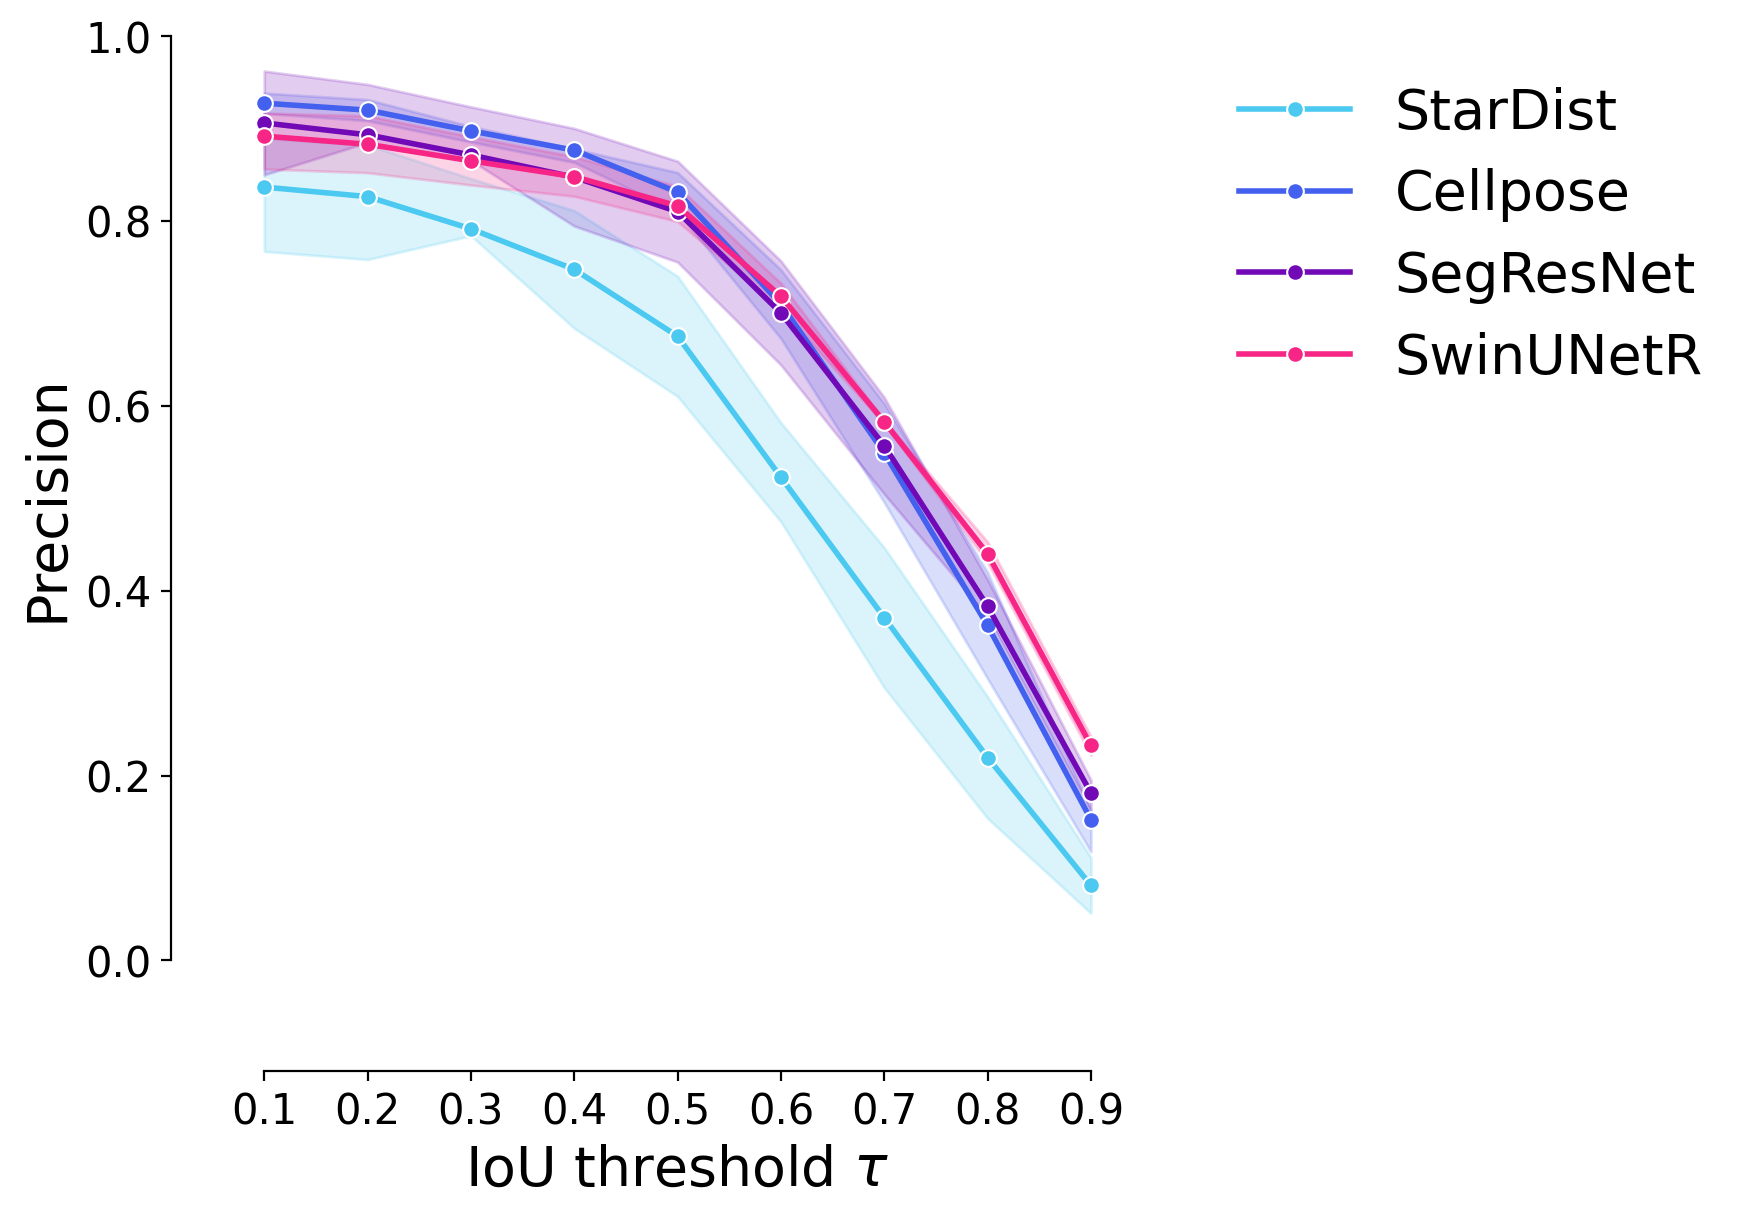

In [12]:
plot_stat_comparison_fold(df_supervised, stat="precision")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("precision_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("precision_comparison_fold.svg", bbox_inches = "tight")

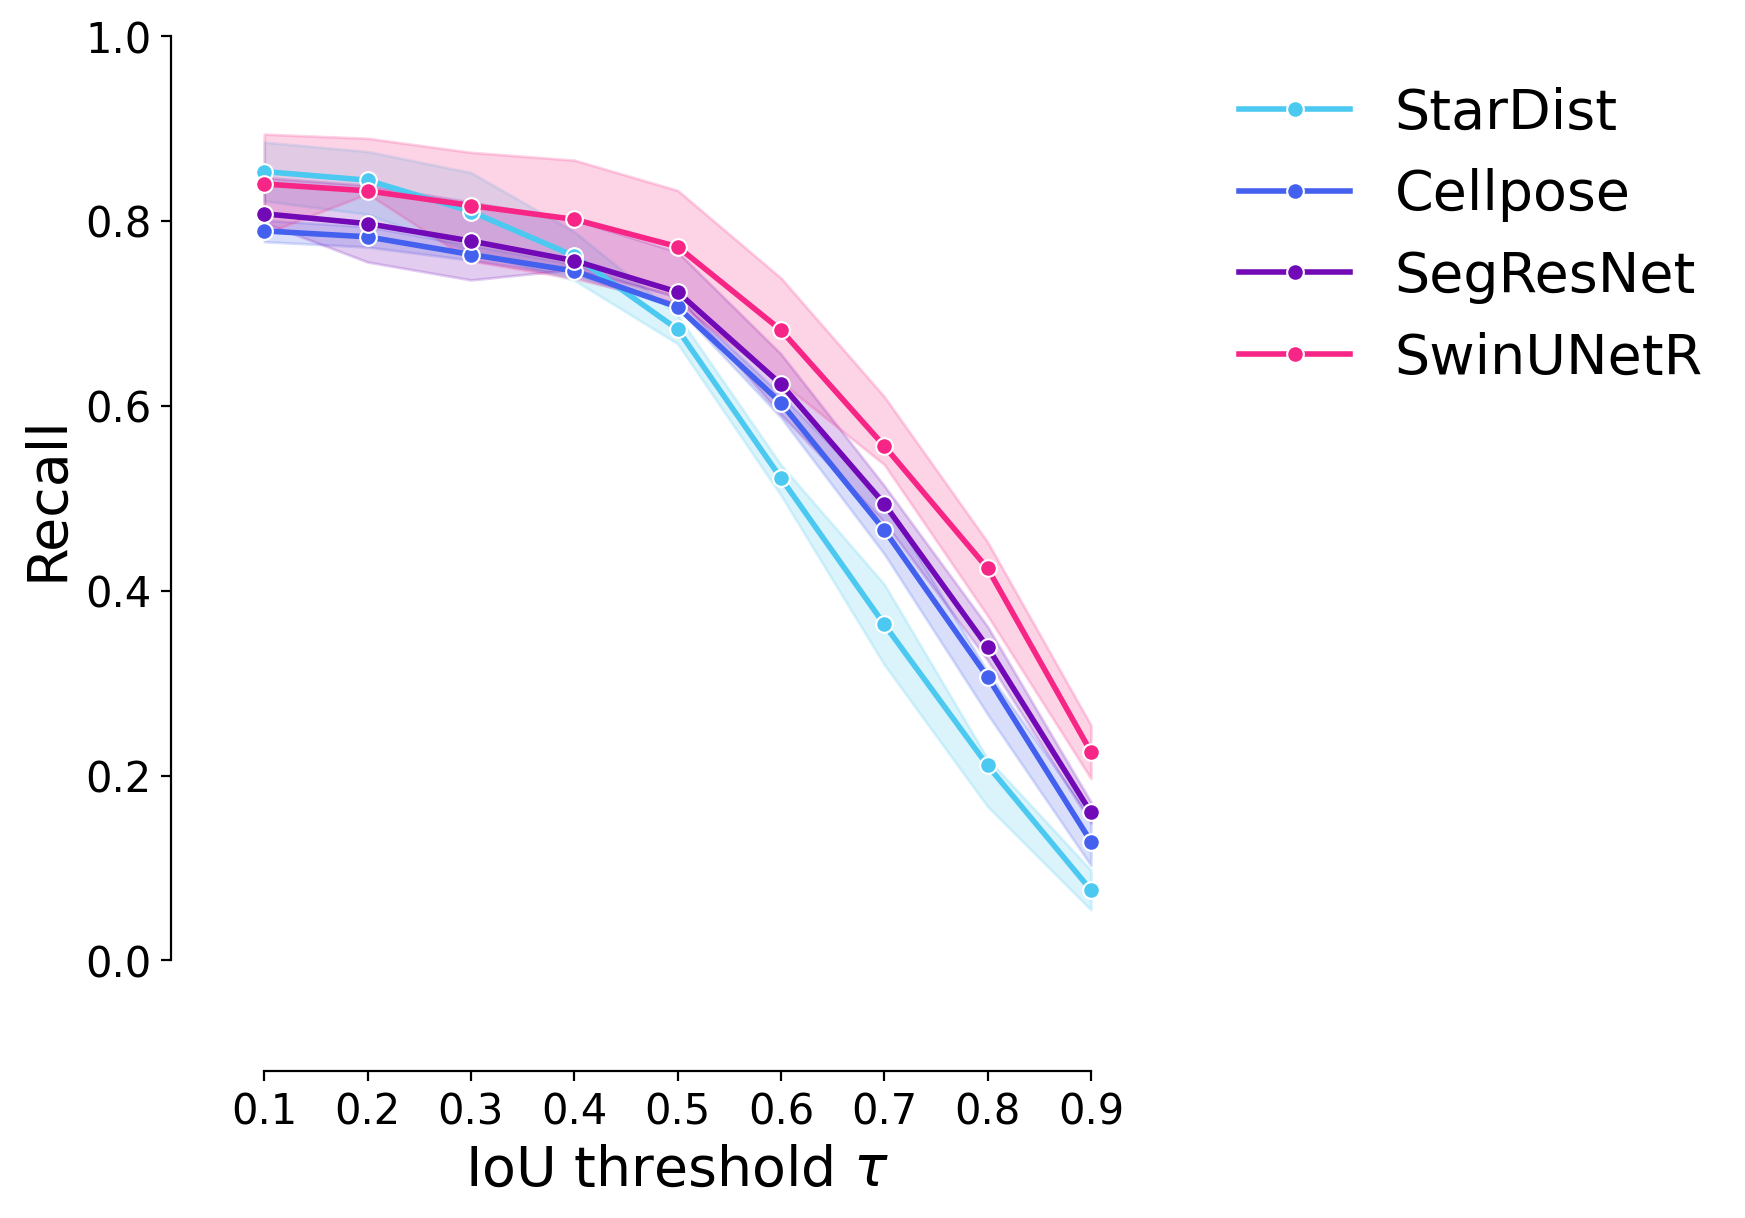

In [13]:
plot_stat_comparison_fold(df_supervised, stat="recall")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("recall_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("recall_comparison_fold.svg", bbox_inches = "tight")

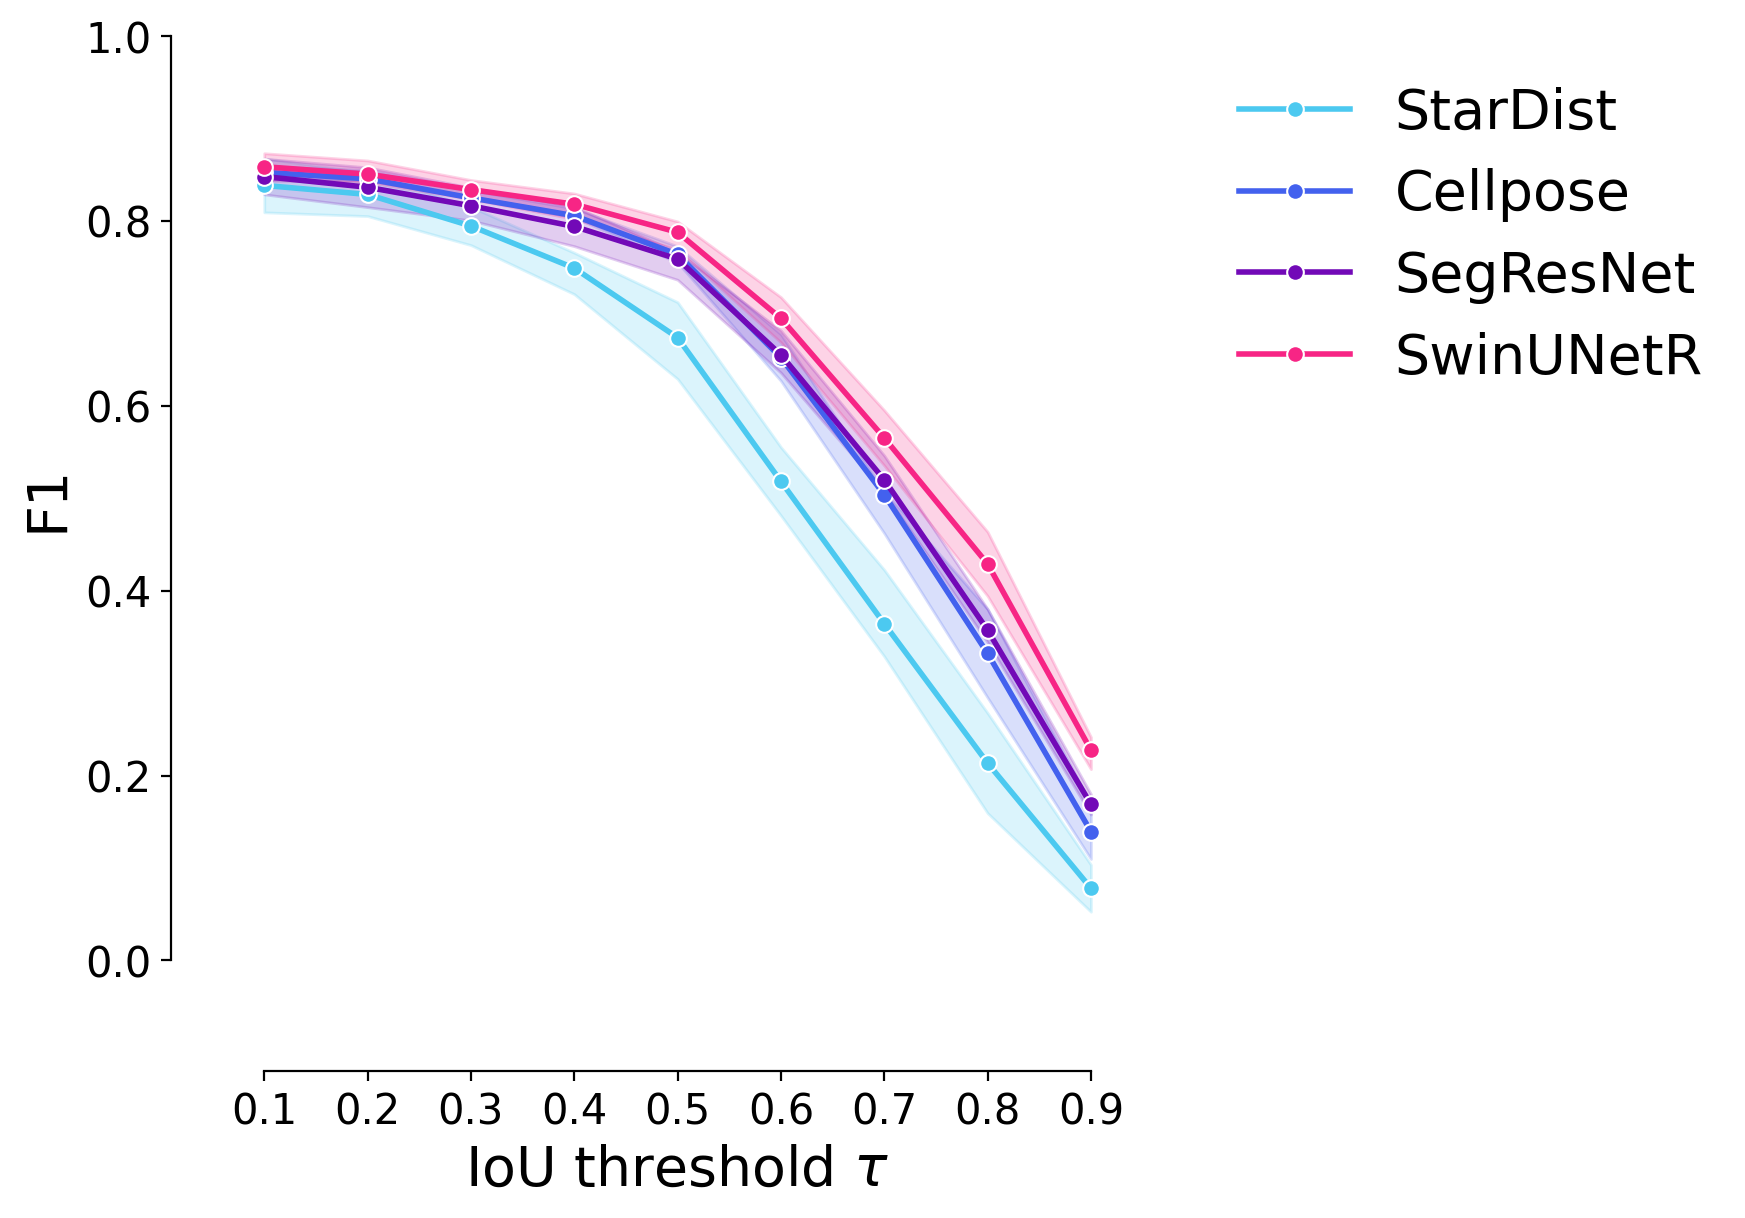

In [14]:
plot_stat_comparison_fold(df_supervised, stat="f1")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("f1_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("f1_comparison_fold.svg", bbox_inches = "tight")

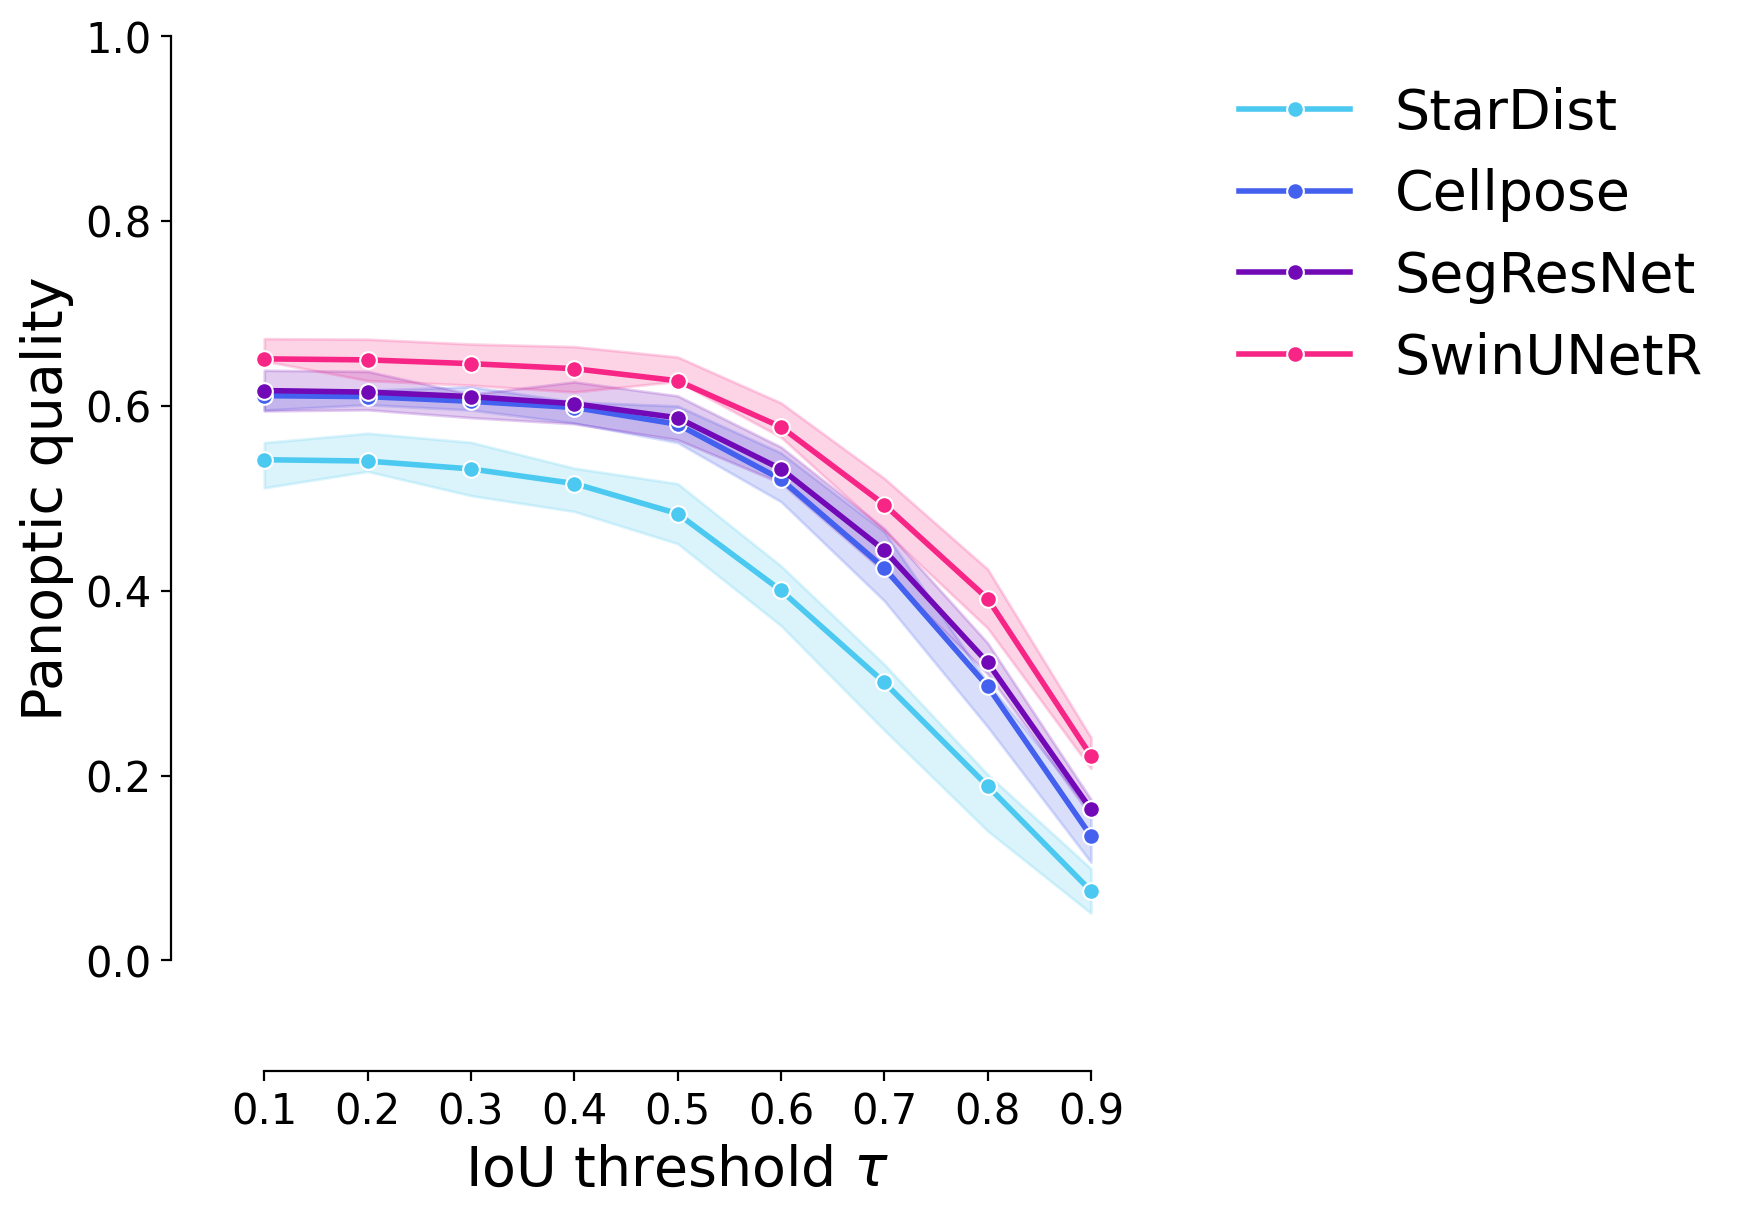

In [15]:
plot_stat_comparison_fold(df_supervised, stat="panoptic_quality")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("panoptic_quality_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("panoptic_quality_comparison_fold.svg", bbox_inches = "tight")

In [16]:
# evaluate stats for WNet3D on an extra fold, where visual is restricted to [50:, :, :]
stats = [matching_dataset(
    GT_labels[0][:50,:,:], wnet_instance[0][:50,:,:], thresh=t, show_progress=False
    ) for t in taus]
partial_df = dataset_matching_stats_to_df(stats)
partial_df["Model"] = "WNet3D - No artifacts"
partial_df["Fold"] = 1
partial_df["thresh"] = partial_df.index
partial_df.set_index(["Model", "Fold", "thresh"], inplace=True)
df = pd.concat([df, partial_df])

In [17]:
df

criterion    fp    tp    fn  precision  \
Model                 Fold thresh                                          
StarDist              1    0.1          iou  1395  2973   412   0.680632   
                           0.2          iou  1405  2963   422   0.678342   
                           0.3          iou  1482  2886   499   0.660714   
                           0.4          iou  1727  2641   744   0.604625   
                           0.5          iou  2127  2241  1144   0.513049   
...                                     ...   ...   ...   ...        ...   
WNet3D - No artifacts 1    0.5          iou   376  2190   854   0.853468   
                           0.6          iou   660  1906  1138   0.742790   
                           0.7          iou  1012  1554  1490   0.605612   
                           0.8          iou  1463  1103  1941   0.429852   
                           0.9          iou  2071   495  2549   0.192907   

                                     recall  accuracy        f1  n_true  \
Model                 Fold thresh                                         
StarDist              1    0.1     0.878287  0.621967  0.766929    3385   
                           0.2     0.875332  0.618580  0.764349    3385   
                           0.3     0.852585  0.592973  0.744486    3385   
                           0.4     0.780207  0.516628  0.681285    3385   
                           0.5     0.662038  0.406567  0.578099    3385   
...                                     ...       ...       ...     ...   
WNet3D - No artifacts 1    0.5     0.719448  0.640351  0.780749    3044   
                           0.6     0.626150  0.514579  0.679501    3044   
                           0.7     0.510512  0.383136  0.554011    3044   
                           0.8     0.362352  0.244730  0.393226    3044   
                           0.9     0.162615  0.096774  0.176471    3044   

                                   n_pred  mean_true_score  \
Model                 Fold thresh                            
StarDist              1    0.1       4368         0.537485   
                           0.2       4368         0.537034   
                           0.3       4368         0.531009   
                           0.4       4368         0.506039   
                           0.5       4368         0.454747   
...                                   ...              ...   
WNet3D - No artifacts 1    0.5       2566         0.560445   
                           0.6       2566         0.510604   
                           0.7       2566         0.435460   
                           0.8       2566         0.324968   
                           0.9       2566         0.156949   

                                   mean_matched_score  panoptic_quality  \
Model                 Fold thresh                                         
StarDist              1    0.1               0.611970          0.469338   
                           0.2               0.613520          0.468944   
                           0.3               0.622822          0.463682   
                           0.4               0.648597          0.441879   
                           0.5               0.686888          0.397089   
...                                               ...               ...   
WNet3D - No artifacts 1    0.5               0.778992          0.608197   
                           0.6               0.815466          0.554110   
                           0.7               0.852986          0.472564   
                           0.8               0.896830          0.352657   
                           0.9               0.965155          0.170321   

                                   by_image  
Model                 Fold thresh            
StarDist              1    0.1        False  
                           0.2        False  
                           0.3        False  
                           0.4        False  
          

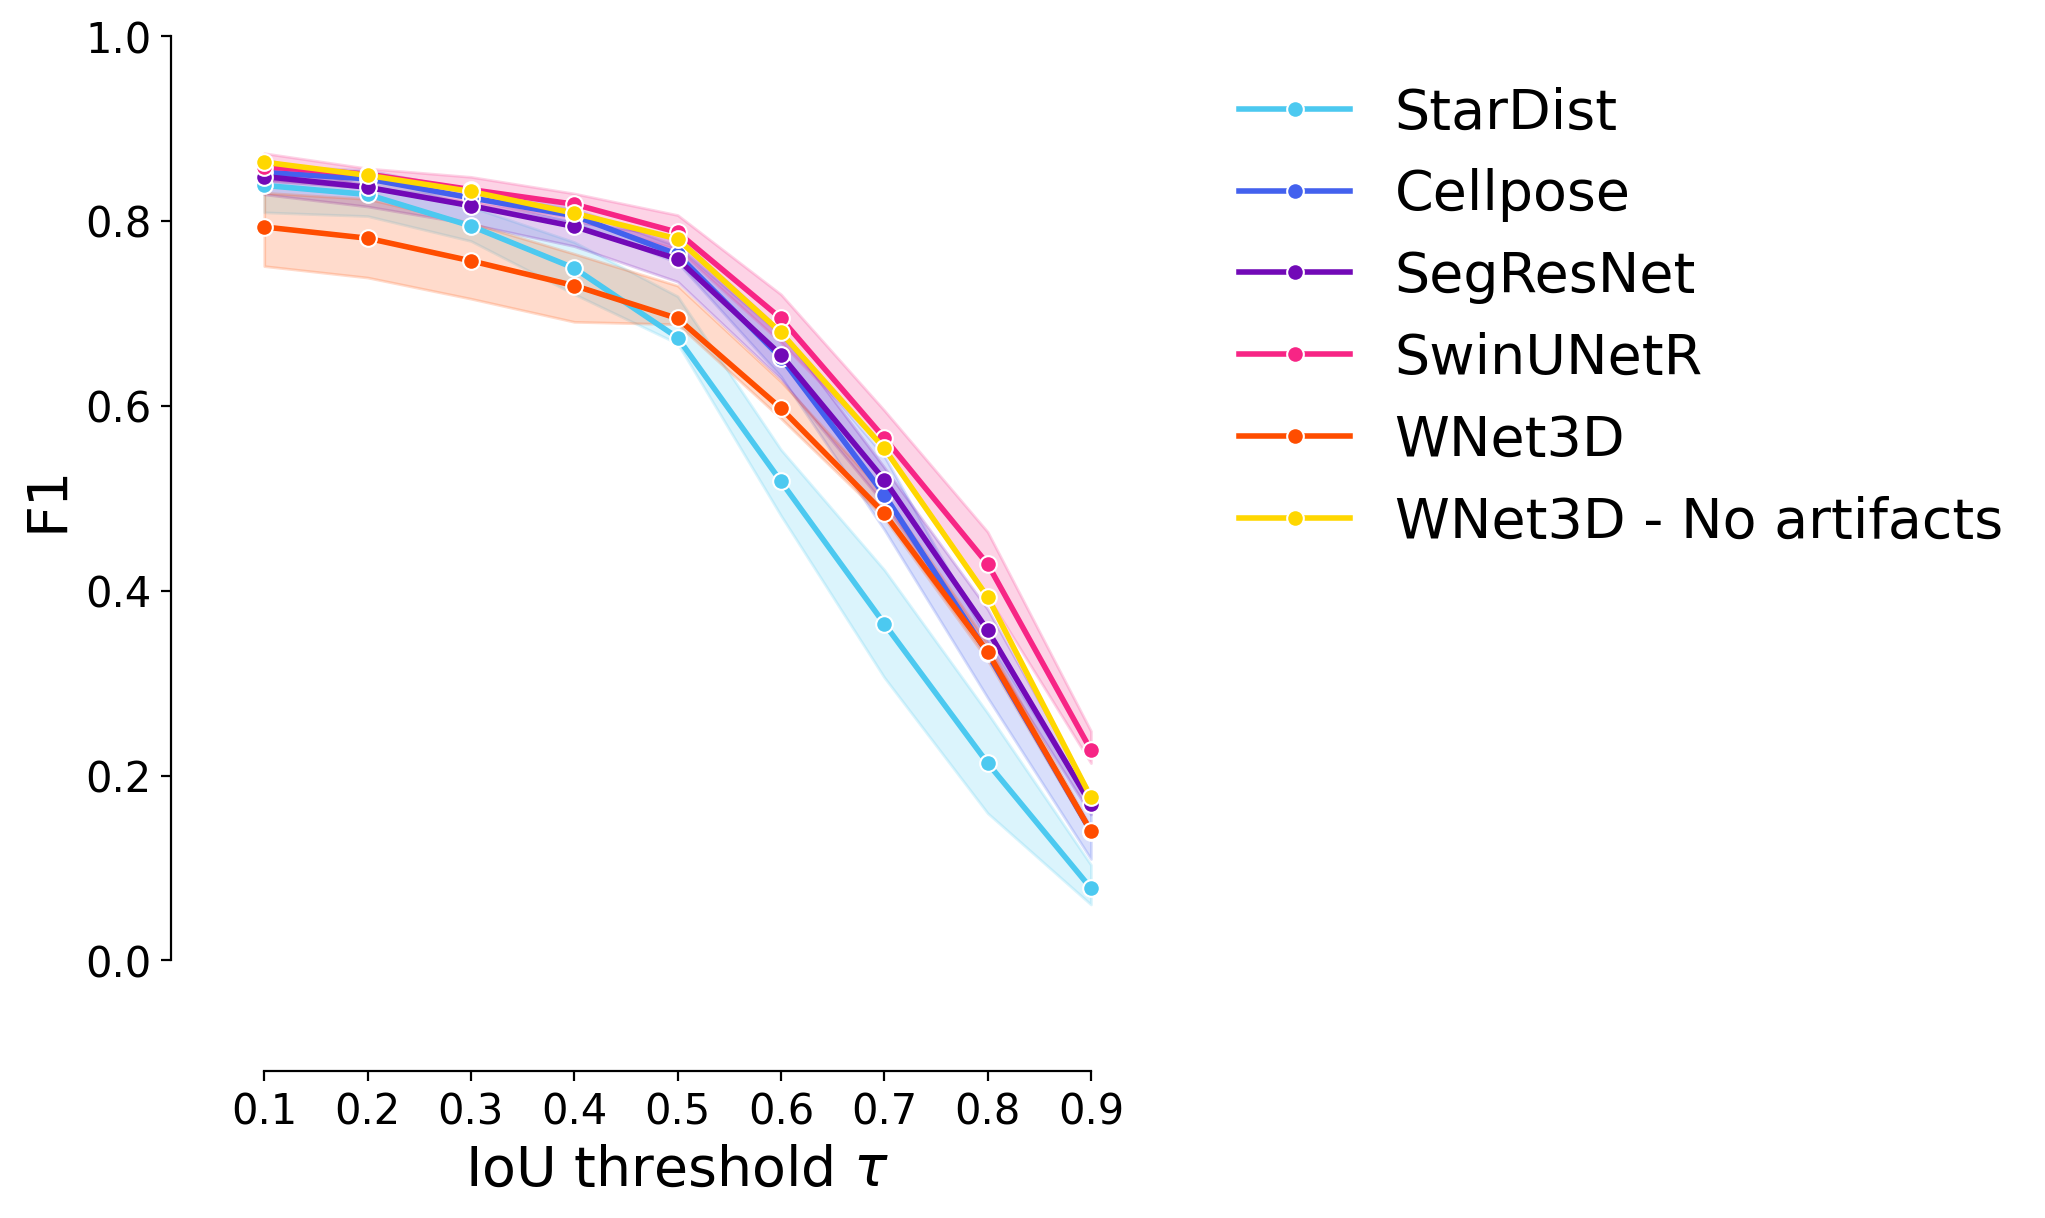

In [18]:
plot_stat_comparison_fold(df, stat="f1")

1536085948.py (1): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

1536085948.py (1): The palette list has more values (8) than needed (6), which may not be intended.


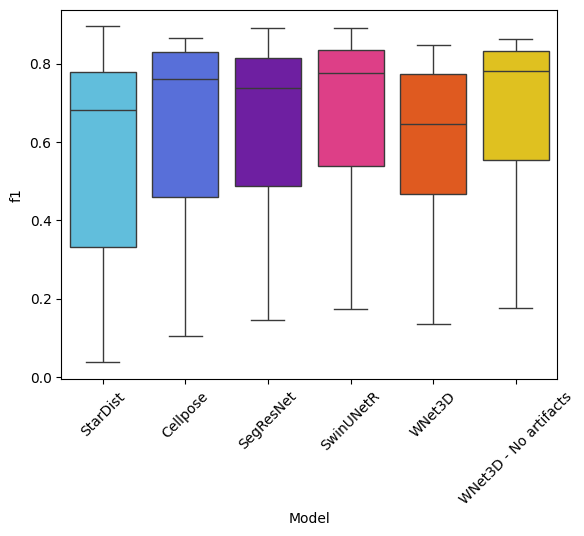

In [19]:
sns.boxplot(data=df, x="Model", y="f1", palette=COLORMAP)
plt.xticks(rotation=45)
plt.show()

In [20]:
from scipy.stats import f_oneway, kruskal

models_f1_means = df.groupby("Model").f1.mean()

f1_starDist = df.loc["StarDist"].f1
f1_cellpose = df.loc["Cellpose"].f1
f1_segresnet = df.loc["SegResNet"].f1
f1_swin = df.loc["SwinUNetR"].f1
f1_wnet = df.loc["WNet3D"].f1
f1_wnet_partial = df.loc["WNet3D - No artifacts"].f1

anova_test = f_oneway(
    # f1_starDist, 
    f1_cellpose, 
    f1_segresnet, 
    f1_swin, 
    f1_wnet, 
    f1_wnet_partial
    )
print("ANOVA test: ", anova_test)

ANOVA test:  F_onewayResult(statistic=0.4660165757160163, pvalue=0.7605465068261601)


In [21]:
# Significant difference between the models?
kruskal_test = kruskal(
    f1_starDist,
    f1_cellpose, 
    f1_segresnet, 
    f1_swin, 
    f1_wnet, 
    f1_wnet_partial
    )
print("Comparisons of F1 scores between all models:")
print("- StarDist\n- Cellpose\n- SegResNet\n- SwinUNetR\n- WNet3D\n- WNet3D - No artifacts")
print("Kruskal-Wallis test: ", kruskal_test)

Comparisons of F1 scores between all models:
- StarDist
- Cellpose
- SegResNet
- SwinUNetR
- WNet3D
- WNet3D - No artifacts
Kruskal-Wallis test:  KruskalResult(statistic=5.021370796083488, pvalue=0.41327764021418123)


In [22]:
# Best models - significant difference between them?
kruskal_test = kruskal(
    # f1_starDist, 
    f1_cellpose, 
    f1_segresnet, 
    f1_swin, 
    f1_wnet, 
    f1_wnet_partial
    )
print("Comparisons of F1 scores between the best models:")
print("- Cellpose\n- SegResNet\n- SwinUNetR\n- WNet3D\n- WNet3D - No artifacts")
print("Kruskal-Wallis test: ", kruskal_test)

Comparisons of F1 scores between the best models:
- Cellpose
- SegResNet
- SwinUNetR
- WNet3D
- WNet3D - No artifacts
Kruskal-Wallis test:  KruskalResult(statistic=3.710657202182631, pvalue=0.4465777918818482)


In [23]:
# Best supervised models - significant difference between them?
kruskal_test = kruskal(
    f1_cellpose, 
    f1_segresnet, 
    f1_swin
    )
print("Comparisons of F1 scores between the best supervised models:")
print("- Cellpose\n- SegResNet\n- SwinUNetR")
print("Kruskal-Wallis test: ", kruskal_test)

Comparisons of F1 scores between the best supervised models:
- Cellpose
- SegResNet
- SwinUNetR
Kruskal-Wallis test:  KruskalResult(statistic=0.6194921208470987, pvalue=0.7336332310839804)
